In [124]:
import numpy as np
import os
import sys
from IPython.display import display, Image
import pickle
from scipy import ndimage, misc
import cv2
#import matplotlib.image as mpimg
#from PIL import Image
import matplotlib.pyplot as plt
# Config the matlotlib backend as plotting inline in IPython
%matplotlib inline

## Show random images from cameras

Assuming images are already extracted from rosbag file.

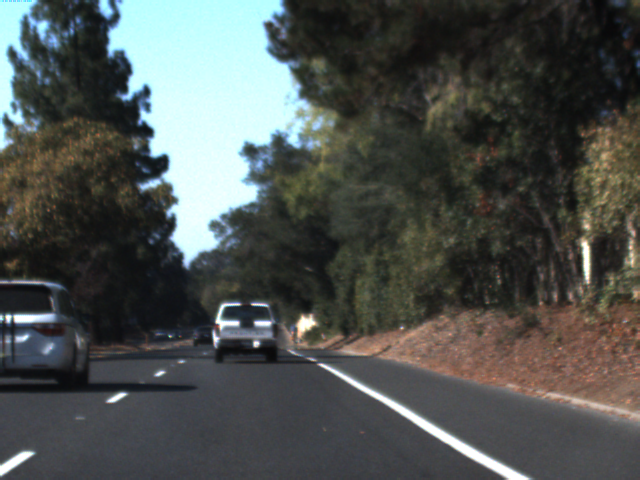

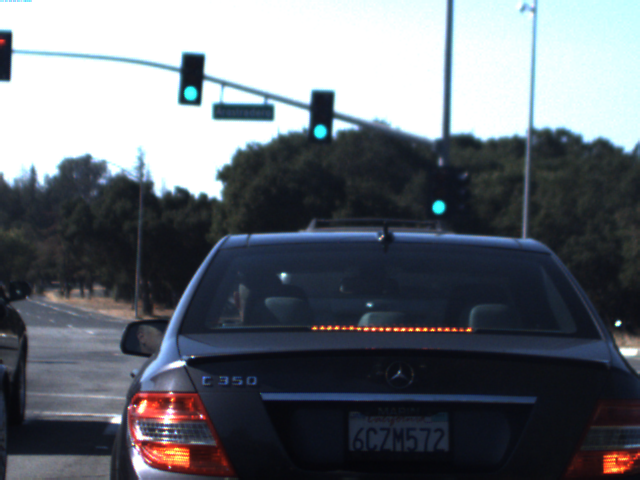

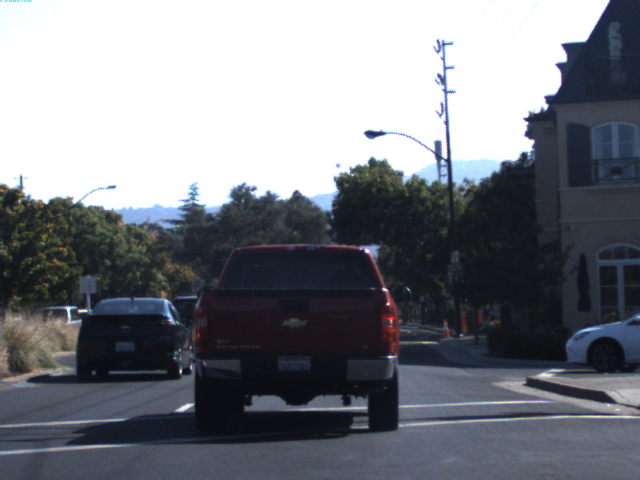

In [80]:
image_folders = ['data/center_camera', 'data/left_camera', 'data/right_camera']

for i in range(len(image_folders)):
    display(Image(os.path.join(image_folders[i], np.random.choice(os.listdir(image_folders[i])))))

## Pickle  resized images

In [136]:
image_width = 640
image_height = 480
image_width_small = 160
image_height_small = 120
num_channels = 3
pixel_depth = 255.0  # Number of levels per pixel.

def load_image(folder, min_num_images):
    """Load the data for a single letter label."""
    image_files = os.listdir(folder)
    dataset = np.ndarray(shape=(len(image_files), image_height_small, image_width_small, num_channels),
                         dtype=np.float32)
    print(folder)
    num_images = 0
    
    for image in image_files:
        image_file = os.path.join(folder, image)
        try:
            #image_data = cv2.imread(image_file, cv2.IMREAD_UNCHANGED)
            image_data = ndimage.imread(image_file)
            #image_data = mpimg.imread(image_file)
            #image_data = np.ndarray((Image.open(image_file).getdata()))
            
            if image_data is None:
                print('Could not read:', image_file, '- it\'s ok, skipping.')
                continue
                
            image_data = cv2.resize(image_data,(image_width_small, image_height_small))
            #image_data = misc.imresize(image_data, [image_height_small, image_width_small])# / pixel_depth
            
            if image_data.shape != (image_height_small, image_width_small, num_channels):
                raise Exception('Unexpected image shape: %s' % str(image_data.shape))
            
            dataset[num_images, :, :] = image_data
            num_images = num_images + 1
            
        except IOError as e:
          print('Could not read:', image_file, ':', e, '- it\'s ok, skipping.')
    
    dataset = dataset[0:num_images, :, :]
    if num_images < min_num_images:
        raise Exception('Many fewer images than expected: %d < %d' %
                    (num_images, min_num_images))
    
    print('Full dataset tensor:', dataset.shape)
    print('Mean:', np.mean(dataset))
    print('Standard deviation:', np.std(dataset))
    return dataset
        
def maybe_pickle(data_folders, min_num_images_per_folder, force=False):
    dataset_names = []
    
    for folder in data_folders:
        set_filename = '{}@{}x{}.pickle'.format(folder, image_height_small, image_width_small)
        dataset_names.append(set_filename)
        if os.path.exists(set_filename) and not force:
            # You may override by setting force=True.
            print('%s already present - Skipping pickling.' % set_filename)
        else:
            print('Pickling %s.' % set_filename)
            dataset = load_image(folder, min_num_images_per_folder)
            
            try:
                
                # workaround for issue https://bugs.python.org/issue24658
                n_bytes = 2**31
                max_bytes = 2**31 - 1
                
                ## write
                bytes_out = pickle.dumps(dataset)
                
                with open(set_filename, 'wb') as f_out:
                    for idx in range(0, n_bytes, max_bytes):
                        f_out.write(bytes_out[idx:idx+max_bytes])
                
                #with open(set_filename, 'wb') as f:
                    #pickle.dump(dataset, f, pickle.HIGHEST_PROTOCOL)
                    
            except Exception as e:
                print('Unable to save data to', set_filename, ':', e)

    return dataset_names

train_datasets = maybe_pickle(image_folders, 15212, True)

Pickling data/center_camera@120x160.pickle.
data/center_camera
Could not read: data/center_camera/.DS_Store : cannot identify image file 'data/center_camera/.DS_Store' - it's ok, skipping.
Full dataset tensor: (15212, 120, 160, 3)
Mean: 92.7361
Standard deviation: 86.8814
Pickling data/left_camera@120x160.pickle.
data/left_camera
Full dataset tensor: (15212, 120, 160, 3)
Mean: 95.8681
Standard deviation: 86.2666
Pickling data/right_camera@120x160.pickle.
data/right_camera
Full dataset tensor: (15212, 120, 160, 3)
Mean: 95.1376
Standard deviation: 88.1209


## Check random image

Frame 3


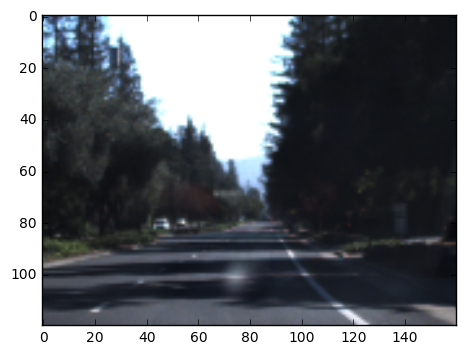

In [135]:
# check images are ok
    
pickle_file = train_datasets[0]

bytes_in = bytearray(0)
input_size = os.path.getsize(pickle_file)

with open(pickle_file, 'rb') as f_in:
    
    max_bytes = 2**31 - 1
    
    for _ in range(0, input_size, max_bytes):
        bytes_in += f_in.read(max_bytes)

    images = pickle.loads(bytes_in)
    #images = pickle.load(f)  # unpickle
    
    sample_idx = np.random.randint(len(images))  # pick a random image index
    sample_image = images[sample_idx, :, :, :]  # extract a 2D slice
    
    print('Frame {}'.format(sample_idx))
    plt.imshow(sample_image/pixel_depth)

## Getting steering angles for each frame

In [55]:
import pandas as pd

In [141]:
ts_center = pd.read_csv('data/timestamps-center.csv', names=['timestamp'])
ts_left = pd.read_csv('data/timestamps-left.csv', names=['timestamp'])
ts_right = pd.read_csv('data/timestamps-right.csv', names=['timestamp'])
steering = pd.read_csv('data/steering.csv')[['timestamp', 'steering_wheel_angle']]

In [153]:
num_images = 15212
print('Checking if we have 1 timestamp per image')
print(ts_center.shape[0] == num_images)
print(ts_left.shape[0] == num_images)
print(ts_right.shape[0] == num_images)

ts_center['steering_angle'] = np.interp(ts_center.timestamp, steering.timestamp, steering.steering_wheel_angle)
ts_left['steering_angle'] = np.interp(ts_left.timestamp, steering.timestamp, steering.steering_wheel_angle)
ts_right['steering_angle'] = np.interp(ts_right.timestamp, steering.timestamp, steering.steering_wheel_angle)

Checking if we have 1 timestamp per image
True
True
True


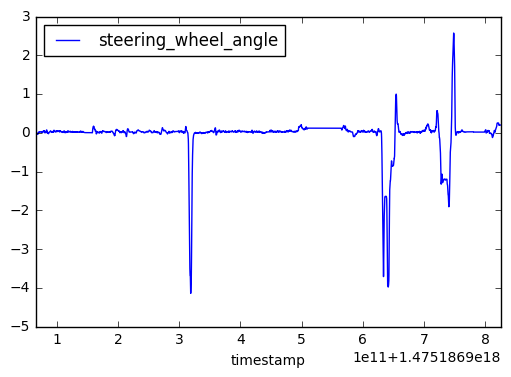

In [147]:
steering.plot('timestamp')

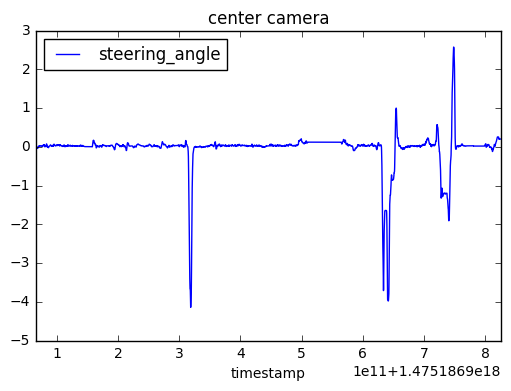

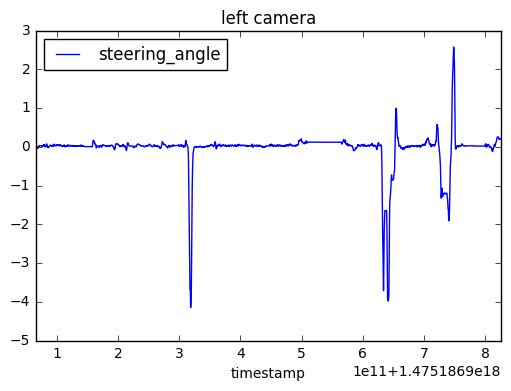

In [158]:
ts_center.plot('timestamp', title='center camera')
ts_left.plot('timestamp', title='left camera')

In [160]:
ts_center.to_csv('data/center_steering.csv', index=False)
ts_left.to_csv('data/left_steering.csv', index=False)
ts_right.to_csv('data/right_steering.csv', index=False)